# Data description & Problem statement: 
The MNIST ("Modified National Institute of Standards and Technology") dataset contains gray-scale images of hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

* Dataset is slightly imbalanced. The data has 28x28 variables (or pixels) in total.
* This is a multi-class classification task. The classification goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

# Workflow:
- Load the dataset
- Data Cleaning/Wrangling: Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)

   #  Model Training:
- Build an Random Forest model, and evaluate it via C-V approach

   # Model Evaluation: 
- Evaluate the RF model with optimized hyperparameters on Test Dataset, by calculating:
     - f1_weighted
     - Confusion matrix

Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/mnist.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

In [3]:
X=df.drop(['5'], axis=1)
y=df['5']

In [4]:
# Building the Initial Model & Cross-Validation: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=RandomForestClassifier(max_features=3, n_estimators=10, max_depth=3,  random_state=42)
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X, y, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.59653465 0.62686567 0.5825     0.57788945 0.5959596 ] 

Accuracy: 0.60 (+/- 0.02)


In [5]:
# Grid-Search for the best model parameters: 

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.model_selection import GridSearchCV

param={'max_features':[3, 4, 5, 8, 9], 'n_estimators': [ 100, 150, 200], 'max_depth':[10, 15, 20, 25, 30]}

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search=GridSearchCV(RandomForestClassifier(random_state=42), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
26,0.919584,0.008466,0.037899,0.000630,15,8,200,"{'max_depth': 15, 'max_features': 8, 'n_estima...",0.878689,0.923841,...,0.909333,0.020315,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41,0.933445,0.008609,0.038762,0.004413,20,8,200,"{'max_depth': 20, 'max_features': 8, 'n_estima...",0.872131,0.920530,...,0.908667,0.022633,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
29,0.993543,0.057930,0.042087,0.005759,15,9,200,"{'max_depth': 15, 'max_features': 9, 'n_estima...",0.888525,0.920530,...,0.908667,0.016026,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [49]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))
print("Log-loss: ", sklearn.metrics.log_loss(y_test, grid_search.predict_proba(X_test)))

Best parameters:  {'max_depth': 15, 'max_features': 8, 'n_estimators': 200}
Best validation accuracy:  0.91 (+/- 0.02)
Test score:  0.91
Log-loss:  0.7152765307578431


Confusion matrix, without normalization
[[45  0  0  0  0  3  0  0  0  0]
 [ 0 48  0  0  0  0  0  0  0  0]
 [ 0  3 37  1  1  0  1  1  0  0]
 [ 0  1  3 50  0  0  1  1  1  0]
 [ 0  1  0  0 51  0  1  0  0  5]
 [ 1  1  0  1  0 28  1  0  0  0]
 [ 1  0  1  0  0  1 50  0  0  0]
 [ 1  0  0  0  0  0  0 41  0  1]
 [ 0  0  0  4  1  1  0  0 47  2]
 [ 1  0  0  0  2  0  1  1  0 57]]
Normalized confusion matrix
[[0.94 0.   0.   0.   0.   0.06 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.07 0.84 0.02 0.02 0.   0.02 0.02 0.   0.  ]
 [0.   0.02 0.05 0.88 0.   0.   0.02 0.02 0.02 0.  ]
 [0.   0.02 0.   0.   0.88 0.   0.02 0.   0.   0.09]
 [0.03 0.03 0.   0.03 0.   0.88 0.03 0.   0.   0.  ]
 [0.02 0.   0.02 0.   0.   0.02 0.94 0.   0.   0.  ]
 [0.02 0.   0.   0.   0.   0.   0.   0.95 0.   0.02]
 [0.   0.   0.   0.07 0.02 0.02 0.   0.   0.85 0.04]
 [0.02 0.   0.   0.   0.03 0.   0.02 0.02 0.   0.92]]


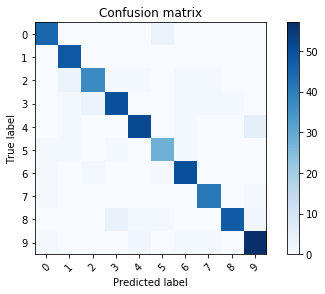

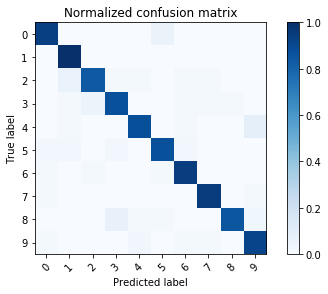

In [50]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, names)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

In [51]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.92      0.94      0.93        48
          1       0.89      1.00      0.94        48
          2       0.90      0.84      0.87        44
          3       0.89      0.88      0.88        57
          4       0.93      0.88      0.90        58
          5       0.85      0.88      0.86        32
          6       0.91      0.94      0.93        53
          7       0.93      0.95      0.94        43
          8       0.98      0.85      0.91        55
          9       0.88      0.92      0.90        62

avg / total       0.91      0.91      0.91       500

